# Optimizer tweaks

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_08 import *

## Imagenette data

We grab the data from the previous notebook.

In [ ]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [ ]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
il = ImageItemList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler)

In [ ]:
bs=64

In [ ]:
train_dl,valid_dl = get_dls(ll.train,ll.valid,bs, num_workers=8)

In [ ]:
x,y = next(iter(valid_dl))

'n03888257'

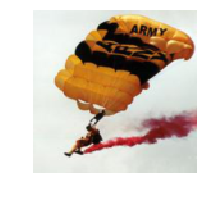

In [ ]:
show_image(x[0])
ll.train.y.processor.vocab[y[0]]

In [ ]:
nfs = [32,64,128,256,512]

In [ ]:
sched = combine_scheds([0.25, 0.75], [sched_cos(0.4/25, 0.4), sched_cos(0.4, 0.)]) 

In [ ]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette),
        partial(ParamScheduler, 'lr', sched)]

In [ ]:
data = DataBunch(train_dl, valid_dl, 3, 10)

This is the baseline of training with vanilla SGD.

In [ ]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [ ]:
run.fit(3, learn)

train: [1.9124067213917326, tensor(0.3359, device='cuda:0')]
valid: [2.0151365966796875, tensor(0.3040, device='cuda:0')]
train: [1.3411626471129983, tensor(0.5552, device='cuda:0')]
valid: [1.173794921875, tensor(0.6240, device='cuda:0')]
train: [0.9769951897442609, tensor(0.6884, device='cuda:0')]
valid: [0.938296630859375, tensor(0.7280, device='cuda:0')]


## Weight decay

Weight decay comes from the idea of L2 regularization, which consists in adding to your loss function the sum of all the weights squared. Why do that? Because when we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.

Why would it prevent overfitting? The idea is that the larger the coefficient are, the more sharp canyons we will have in the loss function. If we take the basic example of parabola, `y = a * (x**2)`, the larger `a` is, the more *narrow* the parabola is.

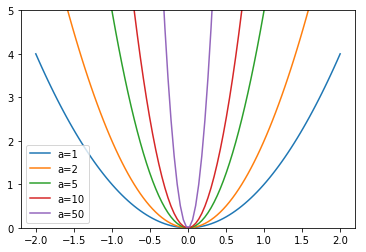

In [ ]:
x = torch.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots()
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

So by letting our model learn high parameters, it might fit all the data points in the training set with an over-complex function that has very sharp changes, which will lead to overfitting.

<img src="images/overfit.png" alt="Fitting vs over-fitting" width="600">

Limiting our weights from growing to much is going to hinder the training of the model, but it will yield to a state where it generalizes better. Going back to the theory a little bit, weight decay (or just `wd`) is a parameter that controls that sum of squares we add to our loss:
``` python
loss_with_wd = loss + (wd / 2) * sum([(p ** 2).sum() for p in model_parameters])
```

In practice though, it would be very inefficient (and maybe numerically unstable) to compute that big sum and add it to the loss. If you remember a little bit of high schoool math, you should now that the derivative of `p ** 2` with respect to `p` is simple `2 * p`, so adding that big sum to our loss is exactly the same as doing
``` python
weight.grad += wd * weight
```

for every weight in our model, which is equivalent to (in the case of vanilla SGD) updating the parameters
with
``` python
new_weight = weight - lr * weight.grad - lr * wd * weight
```

This last formula explains why the name of this technique is weight decay, as each weight is decayed by a factor `lr * wd`. 

This only works for standard SGD, as we have seen that with momentum, RMSProp or in Adam, the update has some additional formulas around the gradient. In those cases, the formula that comes from L2 regularization:
``` python
weight.grad += wd * weight
```
is different than weight decay
``` python
new_weight = weight - lr * weight.grad - lr * wd * weight
```

Most libraries use the first one, but as it was pointed out in [Decoupled Weight Regularization](https://arxiv.org/pdf/1711.05101.pdf) by Ilya Loshchilov and Frank Hutter, it is better to use the second one with the Adam optimizer, which is why fastai made it its default.

In [ ]:
class Optimizer(optim.Optimizer):
    def __init__(self, params, steppers, **defaults): 
        super().__init__(params, defaults)
        self.steppers = listify(steppers)
        
    def step(self):
        for pg in self.param_groups:
            for p in pg['params']:
                if p.grad is not None: compose(p, self.steppers, pg=pg)

Weight decay is substracting `lr x wd x weights` to the weights

In [ ]:
class WeightDecay():
    _defaults = dict(wd=0.)
    def __call__(self,p,pg):
        p.data.mul_(1 - pg['lr'] * pg['wd'])
        return p

L2 regularization is adding `wd x weight` to the gradients.

In [ ]:
class L2_Reg():
    _defaults = dict(wd=0.)
    def __call__(self,p,pg):
        p.grad.data.add_(pg['wd'], p.data)
        return p

And this is the classic SGD step.

In [ ]:
def sgd_step(p, pg):
    p.data.add_(-pg['lr'], p.grad.data)
    return p

## Refining the optimizer

A stepper may introduce new hyperparameters so we associate a `_defaults` variable to it to make sure it's present in the param groups.

In [ ]:
class Optimizer(optim.Optimizer):
    def __init__(self, params, steppers, **defaults): 
        self.steppers = listify(steppers)
        stepper_defaults = {}
        for stepper in self.steppers: stepper_defaults.update(getattr(stepper,'_defaults',{}))
        super().__init__(params, {**stepper_defaults, **defaults})
        
    def step(self):
        for pg in self.param_groups:
            for p in pg['params']:
                if p.grad is not None: compose(p, self.steppers, pg=pg)

In [ ]:
opt_func = partial(Optimizer, steppers=[WeightDecay(), sgd_step])

In [ ]:
model = learn.model

In [ ]:
opt = opt_func(model.parameters(), lr=0.1)
opt.param_groups[0]['wd'],opt.param_groups[0]['lr']

(0.0, 0.1)

In [ ]:
opt = opt_func(model.parameters(), lr=0.1, wd=1e-4)
opt.param_groups[0]['wd']

0.0001

In [ ]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=partial(opt_func, wd=0.01))

In [ ]:
run.fit(3, learn)

train: [1.8981493936133085, tensor(0.3393, device='cuda:0')]
valid: [1.958132568359375, tensor(0.3380, device='cuda:0')]
train: [1.4495471488676903, tensor(0.5189, device='cuda:0')]
valid: [1.43742529296875, tensor(0.5160, device='cuda:0')]
train: [1.0363493467164961, tensor(0.6788, device='cuda:0')]
valid: [0.894203369140625, tensor(0.7360, device='cuda:0')]


## With momentum

Momentum requires to add some state. We need to save the moving average of the gradients to be able to do the step and store this inside the optimizer state if we want it saved by PyTorch (when doing checkpointing).

In [ ]:
class StatefulOptimizer(optim.Optimizer):
    def __init__(self, params, steppers, stats=None, **defaults): 
        self.steppers,self.stats = listify(steppers),listify(stats)
        base_defaults = {}
        for stepper in self.steppers: base_defaults.update(getattr(stepper,'_defaults',{}))
        for stat in self.stats:       base_defaults.update(getattr(stat,'_defaults',{}))
        super().__init__(params, {**base_defaults, **defaults})
        
    def step(self):
        for pg in self.param_groups:
            for p in pg['params']:
                if p.grad is not None:
                    if p not in self.state:
                        init_state = {}
                        for stat in self.stats: init_state.update(stat.init_state(p))
                        self.state[p] = init_state
                    state = self.state[p]
                    for stat in self.stats: state = stat.update(p, pg, state)
                    compose(p, self.steppers, pg=pg, state=state)
                    self.state[p] = state

In [ ]:
class Stat():
    _defaults = {}
    def init_state(self, p):        raise NotImplementedError
    def update(self, p, pg, state): raise NotImplementedError    

In [ ]:
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)

    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, pg, state):
        state['grad_avg'].mul_(pg['mom']).add_(p.grad.data)
        return state

We update the previous classes/functions to take the new `state` argument.

In [ ]:
class WeightDecay():
    _defaults = dict(wd=0.)
    def __call__(self,p,pg,state):
        p.data.mul_(1 - pg['lr'] * pg['wd'])
        return p

In [ ]:
class L2_Reg():
    _defaults = dict(wd=0.)
    def __call__(self,p,pg,state):
        p.grad.data.add_(pg['wd'], p.data)
        return p

In [ ]:
def sgd_step(p, pg,state):
    p.data.add_(-pg['lr'], p.grad.data)
    return p

Then we add the momentum step:

In [ ]:
def momentum_step(p, pg, state):
    p.data.add_(-pg['lr'], state['grad_avg'])
    return p

In [ ]:
sgd_mom = partial(StatefulOptimizer, steppers=momentum_step, stats=AverageGrad())

In [ ]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=sgd_mom)

In [ ]:
run.fit(3, learn)

train: [1.8154774022801303, tensor(0.3647, device='cuda:0')]
valid: [1.7109781494140626, tensor(0.4300, device='cuda:0')]
train: [1.3523889502869553, tensor(0.5452, device='cuda:0')]
valid: [1.12460888671875, tensor(0.6160, device='cuda:0')]
train: [1.00159814218338, tensor(0.6681, device='cuda:0')]
valid: [0.8756005859375, tensor(0.7140, device='cuda:0')]


### Momentum experiments

What does momentum do to the gradients exactly? Let's do some plots to find out!

In [ ]:
x = torch.linspace(-4, 4, 200)
y = torch.randn(200) + 0.3
betas = [0.5,0.7,0.9,0.99]

In [ ]:
def plot_mom(f):
    _,axs = plt.subplots(2,2, figsize=(12,8))
    for beta,ax in zip(betas, axs.flatten()):
        ax.plot(y, linestyle='None', marker='.')
        avg,res = None,[]
        for i,yi in enumerate(y):
            avg,p = f(avg, beta, yi, i)
            res.append(p)
        ax.plot(res, color='red')
        ax.set_title(f'beta={beta}')

This is the regular momentum.

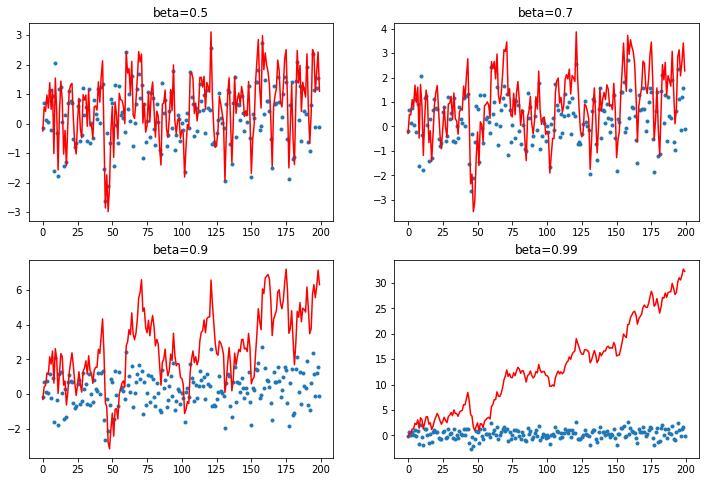

In [ ]:
def mom1(avg, beta, yi, i): 
    if avg is None: avg=yi
    res = beta * avg + yi
    return res,res
plot_mom(mom1)

As we can see, with a too high value, it may go way too high with no way to change its course.

Another way to smooth noisy data is to do an exponentially moving average.

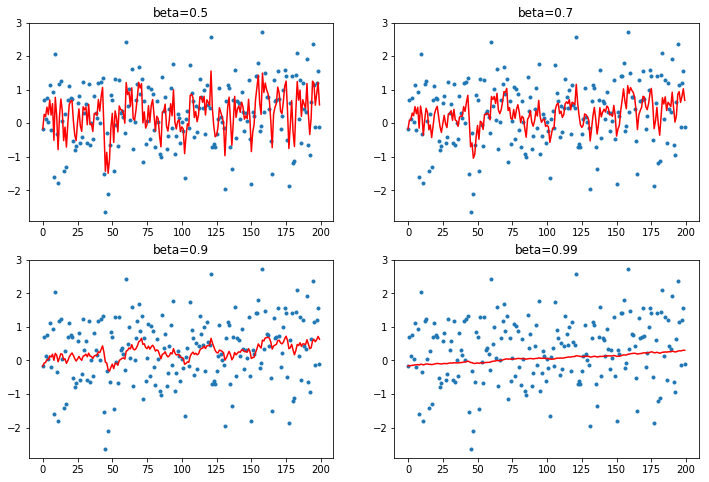

In [ ]:
def mom2(avg, beta, yi, i):
    if avg is None: avg=yi
    avg = beta * avg + (1-beta) * yi
    return avg, avg
plot_mom(mom2)

We can see it gets to a zero-constant when the data is purely random. If the data has a certain shape, it will get that shape (with some delay for high beta).

In [ ]:
y = 1 - (x/3) ** 2 + torch.randn(200) * 0.1

In [ ]:
y[0]=0.5

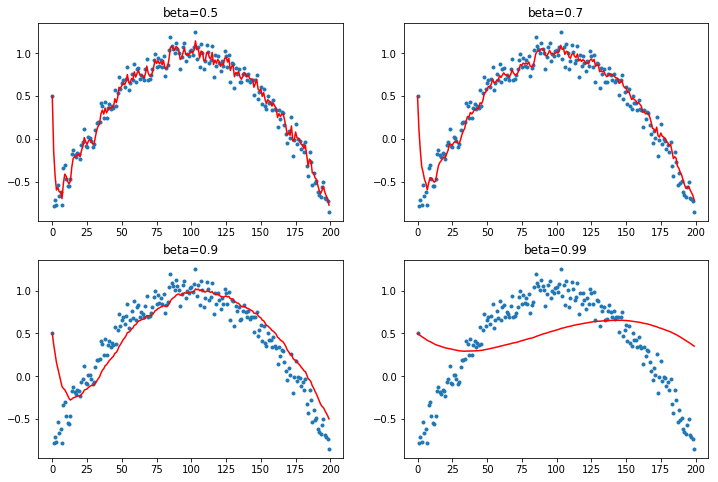

In [ ]:
plot_mom(mom2)

Debiasing is here to correct the wrong information we may have in the very first batch.

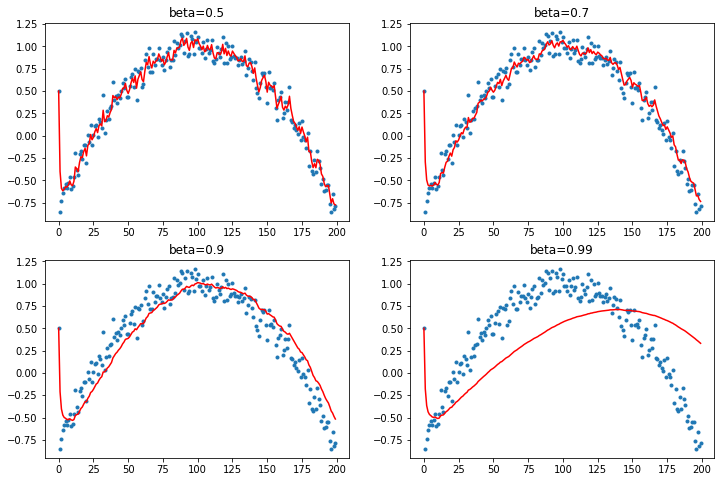

In [ ]:
def mom3(avg, beta, yi, i):
    if avg is None: avg=0
    avg = beta * avg + (1-beta) * yi
    return avg, avg/(1-beta**(i+1))
plot_mom(mom3)

## Adam and friends

In Adam, we use the gradient averages but with dampening, so let's add this to the `AverageGrad` class.

In [ ]:
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    
    def __init__(self, dampening:bool=False): self.dampening=dampening
    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, pg, state):
        pg['mom_damp'] = 1 - pg['mom'] if self.dampening else 1.
        state['grad_avg'].mul_(pg['mom']).add_(pg['mom_damp'], p.grad.data)
        return state

We also need to track the moving average of the gradients squared.

In [ ]:
class AverageSqrGrad(Stat):
    _defaults = dict(sqr_mom=0.99)
    
    def __init__(self, dampening:bool=True): self.dampening=dampening
    def init_state(self, p): return {'sqr_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, pg, state):
        pg['sqr_damp'] = 1 - pg['sqr_mom'] if self.dampening else 1.
        state['sqr_avg'].mul_(pg['sqr_mom']).addcmul_(pg['sqr_damp'],p.grad.data,p.grad.data)
        return state

We also need the number of steps done during training for the debiasing.

In [ ]:
class StepCount(Stat):
    def init_state(self, p): return {'step': 0}
    def update(self, p, pg, state):
        state['step'] += 1
        return state

In [ ]:
def debias(mom, damp, step): return damp * (1 - mom**step) / (1-mom)

Then the Adam step is just the following:

In [ ]:
class AdamStep():
    _defaults = dict(eps=1e-5)
    def __call__(self, p, pg, state):
        debias1 = debias(pg['mom'],     pg['mom_damp'], state['step'])
        debias2 = debias(pg['sqr_mom'], pg['sqr_damp'], state['step'])
        p.data.addcdiv_(-pg['lr'] / debias1, state['grad_avg'], (state['sqr_avg']/debias2 + pg['eps']).sqrt())
        return p

In [ ]:
adam = partial(StatefulOptimizer, steppers=AdamStep(), stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()])

In [ ]:
learn,run = get_learn_run(nfs, data, 0.1, conv_layer, cbs=cbfs, opt_func=adam)

In [ ]:
run.fit(3, learn)

train: [2.089980835320692, tensor(0.2443, device='cuda:0')]
valid: [2.606945068359375, tensor(0.2740, device='cuda:0')]
train: [1.8419557727916085, tensor(0.3501, device='cuda:0')]
valid: [1.6391795654296875, tensor(0.4460, device='cuda:0')]
train: [1.4618398395086862, tensor(0.5004, device='cuda:0')]
valid: [1.3107017822265625, tensor(0.5980, device='cuda:0')]


## LAMB

It's then super easy to implement a new optimizer. This is LAMB from a [very recent paper](https://arxiv.org/pdf/1904.00962.pdf):

$\begin{align}
g_{t}^{l} &= \nabla L(w_{t-1}^{l}, x_{t}) \\
m_{t}^{l} &= \beta_{1} m_{t-1}^{l} + (1-\beta_{1}) g_{t}^{l} \\
v_{t}^{l} &= \beta_{2} v_{t-1}^{l} + (1-\beta_{2}) g_{t}^{l} \odot g_{t}^{l} \\
m_{t}^{l} &= m_{t}^{l} / (1 - \beta_{1}^{t}) \\
v_{t}^{l} &= v_{t}^{l} / (1 - \beta_{2}^{t}) \\
r_{1} &= \|w_{t-1}^{l}\|_{2} \\
s_{t}^{l} &= \frac{m_{t}^{l}}{\sqrt{v_{t}^{l} + \epsilon}} + \lambda w_{t-1}^{l} \\ 
r_{2} &= \| s_{t}^{l} \|_{2} \\
\eta^{l} &= \eta * r_{1}/r_{2} \\ 
w_{t}^{l} &= w_{t}^{l-1} - \eta_{l} * s_{t}^{l} \\
\end{align}$

In [ ]:
class LambStep():
    _defaults = dict(eps=1e-6, wd=0.)
    def __call__(self, p, pg, state):
        debias1 = debias(pg['mom'],     pg['mom_damp'], state['step'])
        debias2 = debias(pg['sqr_mom'], pg['sqr_damp'], state['step'])
        r1 = p.data.pow(2).mean().sqrt()
        step = (state['grad_avg']/ debias1) / (state['sqr_avg']/debias2 + pg['eps']).sqrt() + pg['wd'] * p.data
        r2 = step.pow(2).mean().sqrt()
        p.data.add_(-pg['lr'] * min(r1/r2,10), step)
        return p

In [ ]:
lamb = partial(StatefulOptimizer, steppers=LambStep(), stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()])

In [ ]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=lamb)

In [ ]:
run.fit(3, learn)

train: [2.1830554060997365, tensor(0.2314, device='cuda:0')]
valid: [1.9674951171875, tensor(0.3460, device='cuda:0')]
train: [1.9502472685939196, tensor(0.3281, device='cuda:0')]
valid: [1.61225732421875, tensor(0.4560, device='cuda:0')]
train: [1.5729571106231581, tensor(0.4596, device='cuda:0')]
valid: [1.42828564453125, tensor(0.5340, device='cuda:0')]


Other recent variants of optimizers:
- [Large Batch Training of Convolutional Networks](https://arxiv.org/abs/1708.03888) (LARS also uses weight statistics, not just gradient statistics. Can you add that to this class?)
- [Adafactor: Adaptive Learning Rates with Sublinear Memory Cost](https://arxiv.org/abs/1804.04235) (Adafactor combines stats over multiple sets of axes)
- [Adaptive Gradient Methods with Dynamic Bound of Learning Rate](https://arxiv.org/abs/1902.09843)

## Export

In [ ]:
!python notebook2script.py 09_optimizers.ipynb

Converted 09_optimizers.ipynb to nb_09.py
